<a href="https://colab.research.google.com/github/Gopal-Dahale/QMLHEP-Tasks/blob/main/GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
!wget https://zenodo.org/record/3164691/files/QG_jets.npz -P /content/gdrive/MyDrive/data/

--2022-04-17 09:17:00--  https://zenodo.org/record/3164691/files/QG_jets.npz
Resolving zenodo.org (zenodo.org)... 137.138.76.77
Connecting to zenodo.org (zenodo.org)|137.138.76.77|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 106689379 (102M) [application/octet-stream]
Saving to: ‘/content/gdrive/MyDrive/data/QG_jets.npz’

QG_jets.npz         100%[===================>] 101.75M  22.2MB/s    in 5.7s    

2022-04-17 09:17:08 (17.9 MB/s) - ‘/content/gdrive/MyDrive/data/QG_jets.npz’ saved [106689379/106689379]



In [5]:
from tf_keras_model import get_particle_net_lite,get_particle_net
from tensorflow import keras
import logging
logging.basicConfig(level=logging.INFO, format='[%(asctime)s] %(levelname)s: %(message)s')
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
dataset = np.load('/content/gdrive/MyDrive/data/QG_jets.npz',allow_pickle=True)

In [7]:
list(dataset.keys())

['X', 'y']

In [8]:
x = dataset['X']
y = dataset['y']

In [9]:
print(x.shape)
print(y.shape)

(100000, 139, 4)
(100000,)


In [24]:
# one hot encoding labels is needed else the following error 
# ValueError: Shapes (None, 1) and (None, 2) are incompatible
y = keras.utils.to_categorical(y)
print(y.shape)

(100000, 2)


In [25]:


# From paper
# The first EdgeConv block uses the spatial coordinates
# of the particles in the pseudorapidity-azimuth space to
# compute the distances, while the subsequent blocks use
# the learned feature vectors as coordinates.

# from dataset
# features of each particle are its pt, rapidity, azimuthal angle, and pdgid

# Shapes of each input (`points`, `features`, `mask`)


In [26]:
x, y = shuffle(x, y, random_state=0)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.30, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test , test_size=0.5, random_state=42)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)
print(x_val.shape, y_val.shape)

(70000, 139, 4) (70000, 2)
(15000, 139, 4) (15000, 2)
(15000, 139, 4) (15000, 2)


In [27]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_train = np.sum(x_train, axis=2) 
print(mask_train.shape)
print(mask_train[0])

# make the array binary
mask_train = np.array(mask_train !=0 , np.float32)
print(mask_train[0])

# reshape mask for a third axis
mask_train = mask_train.reshape(x_train.shape[0], x_train.shape[1], 1)
print(mask_train.shape)

(70000, 139)
[   28.21241083    28.2451668   -203.77943386  -204.22062197
   219.95397046    29.37212051    28.72560918    28.34241578
    30.31492072  -204.81407217    28.80688666   329.16866383
  -303.73856726    28.36508214  -199.62940715   221.13697619
  -313.68877911  -201.7219742   -314.82070691   224.03400137
   228.10337039    30.53390014  -202.54415051  2136.67573886
  -202.68101175 -2059.76344811   244.21817136   186.35978846
  -204.38873999    29.42453009   327.58600635    29.42043319
   219.54071861   330.37569035    29.12706946  -203.57318239
   226.16555755   155.34007804  -196.94699223   225.31540353
    35.78734424    32.10889204  -283.26038176   348.3404927
    50.01680383    73.56943074   229.58486108  -201.25236118
    33.21071513  -190.43525136   218.72732963  -201.3410175
    31.06474332    32.91955989    31.22307026    32.06201168
    47.89815141  -274.37819603    57.89807174     0.
     0.             0.             0.             0.
     0.             0.       

In [28]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_val = np.sum(x_val, axis=2) 

# make the array binary
mask_val = np.array(mask_val !=0 , np.float32)

# reshape mask for a third axis
mask_val = mask_val.reshape(x_val.shape[0], x_val.shape[1], 1)
print(mask_val.shape)

(15000, 139, 1)


In [29]:
# mask
# find the maximum length vector in for each sample in 10000 samples with maximum number of non-zero values
mask_test = np.sum(x_test, axis=2) 

# make the array binary
mask_test = np.array(mask_test !=0 , np.float32)

# reshape mask for a third axis
mask_test = mask_val.reshape(x_test.shape[0], x_test.shape[1], 1)
print(mask_test.shape)

(15000, 139, 1)


In [30]:
train_dataset = {
    'points': x_train[:,:,1:3],
    'features': x_train,
    'mask': mask_train
}

test_dataset = {
    'points': x_test[:,:,1:3],
    'features': x_test,
    'mask': mask_test
}

val_dataset = {
    'points': x_val[:,:,1:3],
    'features': x_val,
    'mask': mask_val
}

In [31]:
shapes = {
    'points': x_train[:,:,1:3].shape[1:],
    'features': x_train.shape[1:],
    'mask': mask_train.shape[1:]
}
shapes

{'features': (139, 4), 'mask': (139, 1), 'points': (139, 2)}

In [32]:
# particle net lite
num_classes = 2
model = get_particle_net_lite(num_classes, shapes)

In [33]:
# Training parameters
batch_size = 1024
epochs = 3

In [34]:
def lr_schedule(epoch):
    lr = 1e-3
    if epoch > 10:
        lr *= 0.1
    elif epoch > 20:
        lr *= 0.01
    logging.info('Learning rate: %f'%lr)
    return lr

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.Adam(learning_rate=lr_schedule(0)),
              metrics=['accuracy'])
model.summary()

[2022-04-17 09:18:24,875] INFO: Learning rate: 0.001000


Model: "ParticleNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 mask (InputLayer)              [(None, 139, 1)]     0           []                               
                                                                                                  
 tf.math.not_equal_1 (TFOpLambd  (None, 139, 1)      0           ['mask[0][0]']                   
 a)                                                                                               
                                                                                                  
 tf.cast_2 (TFOpLambda)         (None, 139, 1)       0           ['tf.math.not_equal_1[0][0]']    
                                                                                                  
 tf.math.equal_1 (TFOpLambda)   (None, 139, 1)       0           ['tf.cast_2[0][0]']    

In [36]:
# Prepare model model saving directory.

save_dir = 'model_checkpoints'
model_name = '%s_model.{epoch:03d}.h5' % 'particle_net_lite'
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
filepath = os.path.join(save_dir, model_name)

# Prepare callbacks for model saving and for learning rate adjustment.
checkpoint = keras.callbacks.ModelCheckpoint(filepath=filepath,
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_schedule)
progress_bar = keras.callbacks.ProgbarLogger()
callbacks = [checkpoint, lr_scheduler, progress_bar]

In [37]:
history = model.fit(train_dataset, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(val_dataset, y_val),
          shuffle=True,
          callbacks=callbacks)

[2022-04-17 09:18:28,833] INFO: Learning rate: 0.001000


Epoch 1/3
      0/Unknown - 589s 0s/sample - loss: 0.5238 - accuracy: 0.7472WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2022-04-17 09:28:38,797] WARNING: Can save best model only with val_acc available, skipping.


69/69 [==============================] - 610s 9s/sample - loss: 0.5238 - accuracy: 0.7472 - val_loss: 0.6721 - val_accuracy: 0.5542 - lr: 0.0010


[2022-04-17 09:28:38,811] INFO: Learning rate: 0.001000


Epoch 2/3
 0/69 [..............................] - ETA: 0s - loss: 0.4820 - accuracy: 0.7760WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2022-04-17 09:38:35,029] WARNING: Can save best model only with val_acc available, skipping.


69/69 [==============================] - 596s 9s/sample - loss: 0.4820 - accuracy: 0.7760 - val_loss: 0.5704 - val_accuracy: 0.7033 - lr: 0.0010


[2022-04-17 09:38:35,048] INFO: Learning rate: 0.001000


Epoch 3/3
 0/69 [..............................] - ETA: 0s - loss: 0.4751 - accuracy: 0.7799WARNING:tensorflow:Can save best model only with val_acc available, skipping.


[2022-04-17 09:48:30,564] WARNING: Can save best model only with val_acc available, skipping.


69/69 [==============================] - 596s 9s/sample - loss: 0.4751 - accuracy: 0.7799 - val_loss: 0.5093 - val_accuracy: 0.7701 - lr: 0.0010


In [39]:
history.history

{'accuracy': [0.7472285628318787, 0.776028573513031, 0.7799285650253296],
 'loss': [0.5238291621208191, 0.4819912910461426, 0.4750930666923523],
 'lr': [0.001, 0.001, 0.001],
 'val_accuracy': [0.5541999936103821, 0.70333331823349, 0.7701333165168762],
 'val_loss': [0.6721423268318176, 0.570405125617981, 0.5092980861663818]}

In [42]:
import json
with open("particle_net_lite_history.json", "w") as outfile:
    outfile.write(str(history.history))

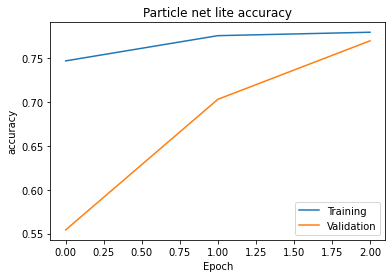

In [43]:
plt.plot(history.history['accuracy'], label='Training')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Particle net lite accuracy')
plt.xlabel('Epoch')
plt.ylabel('accuracy')
plt.legend()
plt.show()

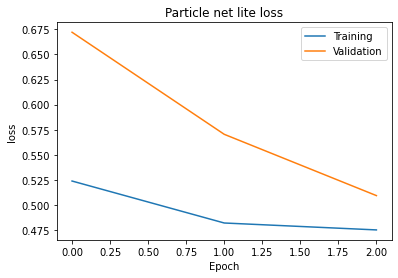

In [44]:
plt.plot(history.history['loss'], label='Training')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Particle net lite loss')
plt.xlabel('Epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [45]:
res = model.evaluate(test_dataset, y_test)

469/469 [==============================] - 27s 58ms/step - loss: 0.5575 - accuracy: 0.7342


In [47]:
print("test loss, test acc:", res)

test loss, test acc: [0.5574674010276794, 0.7342000007629395]
